# Import Libraries

In [83]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn  # nn = neural network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.10.0+cpu
CUDA available: False
CUDA version: None
Using device: cpu


# Read Data
- read data
- filter out slow speeds
    - the observer we want to create is a back emf based one
- split in test and training data

In [84]:
# Load dataset
df = pd.read_csv("../data/raw/angle_estimation_dataset.csv")
print(f"Loaded Dataset with {len(df):,} rows")

# Select the 4 input features (what we measure from the motor)
# i_alpha, i_beta: Current measurements
# v_alpha, v_beta: Voltage measurements
features = ['i_alpha', 'i_beta', 'v_alpha', 'v_beta']
X = df[features].values

# Select the 2 output targets (what we want to predict)
# We predict sin(θ) and cos(θ) instead of angle θ directly because:
# 1. Angles wrap around (360° = 0°) which confuses neural networks
# 2. sin(θ) and cos(θ) are always between -1 and 1
y = df[['sin_theta_e', 'cos_theta_e']].values



# Not include slow speeds during training (emk observer)
speed_threshold = 100
mask = df['omega_e'].abs() >= speed_threshold
X_filtered = X[mask]
y_filtered = y[mask]

# Train-Test Split
# No shuffle to maintain time series order.
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, shuffle=False
)

print("----- Test Train Split -----")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Loaded Dataset with 600,000 rows
----- Test Train Split -----
Training samples: 437625
Testing samples: 109407


# Scale Data
- NN use gradient descent
- gradient descent works best when all features have similar scales
- without scaling: large values dominate, small values ignored

Without scaling:
 Suppose i_alpha ranges 0-100A, i_beta 0-1A
 Weight update: w_new = w_old - learning_rate * gradient
 Gradient for i_alpha will be 100× larger → dominates learning

 With scaling (StandardScaler):
 Each feature: x_scaled = (x - mean) / std
 All features now have mean=0, std=1 → equal importance

In [85]:
"""
WHY SCALE DATA?
Neural networks learn faster when:
- Mean (average) of each feature = 0
- Standard deviation (spread) of each feature = 1
Without scaling, large numbers can dominate and slow learning.
"""

# Create scalers (one for inputs, one for outputs)
scaler_x = StandardScaler()  # For input features
scaler_y = StandardScaler()  # For output targets

# Fit scalers on TRAINING data only (calculate mean and std)
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform test data using SAME scaling (don't fit again!)
X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

print("Data scaled to mean=0, std=1")
print("\nExample - i_alpha before scaling:")
print(f"  Mean: {X_train[:,0].mean():.2f}, Std: {X_train[:,0].std():.2f}")
print("\nExample - i_alpha after scaling:")
print(f"  Mean: {X_train_scaled[:,0].mean():.2f}, Std: {X_train_scaled[:,0].std():.2f}")


Data scaled to mean=0, std=1

Example - i_alpha before scaling:
  Mean: -0.00, Std: 1.67

Example - i_alpha after scaling:
  Mean: -0.00, Std: 1.00


# Neural Network Model
- input layer 4 neurons
- hidden layers 16 with tanh
- output layer 2 neurons

In [86]:

hidden_layer_size = 12
AngleEstimator = nn.Sequential(
    nn.Linear(4, hidden_layer_size),  # i_α, i_β, v_α, v_β → features
    nn.Tanh(),         # Bounded activation for sin/cos
    nn.Linear(hidden_layer_size, 2)   # → sinθ, cosθ
)

model = AngleEstimator
params = sum(p.numel() for p in model.parameters())
print(f"4→{hidden_layer_size}→2 | Params: {params:,} | Size: {params*4/1024:.2f}KB")

4→12→2 | Params: 86 | Size: 0.34KB


# Prepare for training

In [87]:
# Data conversion
X_train, y_train = map(torch.FloatTensor, (X_train_scaled, y_train_scaled))
X_test, y_test = map(torch.FloatTensor, (X_test_scaled, y_test_scaled))

# DataLoader: Efficiently loads data in batches during training
batch_size = 128  # Process 128 samples at once

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=False, # preserve time order
    drop_last=True  # Drop last batch if smaller than batch_size
)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

print(f"Training on {len(X_train)} samples | Batch size: {batch_size}")
print(f"Steps per epoch: {len(train_loader)}")

print("\nLoss function: MSE (Mean Squared Error)")
print("  Lower MSE = better predictions")

Training on 437625 samples | Batch size: 128
Steps per epoch: 3418

Loss function: MSE (Mean Squared Error)
  Lower MSE = better predictions


# train model

In [88]:
EPOCHS = 12
train_losses = []

print(f"Training [{EPOCHS} epochs | Batch size: {batch_size}]")
print("-" * 50)

total_start = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    num_batches = len(train_loader)

    # Optional: Progress bar for batches
    # batch_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for _batch_idx, (inputs, targets) in enumerate(train_loader):
        # 1. Forward pass: predictions
        outputs = model(inputs)
        # 2. Compute loss
        loss = criterion(outputs, targets)

        # 3. Backward pass: gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients

        # 4. Update weights
        optimizer.step()

        # Track statistics
        epoch_loss += loss.item()
        batch_count += 1

    epoch_time = time.time() - epoch_start
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
          f"Loss: {avg_loss:.6f} | "
          f"Time: {epoch_time:.3f}s | "
          f"{len(inputs)} samples/batch")


# Final timing
total_time = time.time() - total_start
print(f"\n{'='*60}")
print("Training Complete!")
print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"Time per epoch: {total_time/EPOCHS:.3f}s")
print(f"Final loss: {train_losses[-1]:.6f}")

Training [12 epochs | Batch size: 128]
--------------------------------------------------
Epoch  1/12 | Loss: 0.078786 | Time: 2.749s | 128 samples/batch
Epoch  2/12 | Loss: 0.027324 | Time: 3.417s | 128 samples/batch
Epoch  3/12 | Loss: 0.012948 | Time: 5.078s | 128 samples/batch
Epoch  4/12 | Loss: 0.007317 | Time: 3.703s | 128 samples/batch
Epoch  5/12 | Loss: 0.004868 | Time: 3.556s | 128 samples/batch
Epoch  6/12 | Loss: 0.003622 | Time: 3.859s | 128 samples/batch
Epoch  7/12 | Loss: 0.003026 | Time: 3.224s | 128 samples/batch
Epoch  8/12 | Loss: 0.002751 | Time: 4.106s | 128 samples/batch
Epoch  9/12 | Loss: 0.002602 | Time: 4.318s | 128 samples/batch
Epoch 10/12 | Loss: 0.002512 | Time: 3.816s | 128 samples/batch
Epoch 11/12 | Loss: 0.002452 | Time: 3.444s | 128 samples/batch
Epoch 12/12 | Loss: 0.002408 | Time: 3.678s | 128 samples/batch

Training Complete!
Total time: 45.0s (0.7 min)
Time per epoch: 3.746s
Final loss: 0.002408


# test the trained model

In [89]:
"""
Now we test on data the model has NEVER seen before.
This tells us if the model actually learned or just memorized.
"""

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    # Make predictions on test set
    test_predictions_scaled = model(X_test)

# Convert back to original scale
test_predictions = scaler_y.inverse_transform(test_predictions_scaled.numpy())
test_targets = scaler_y.inverse_transform(y_test_scaled)

# Extract sin and cos predictions
sin_pred = test_predictions[:, 0]  # Predicted sin(θ)
sin_true = test_targets[:, 0]      # Actual sin(θ)
cos_pred = test_predictions[:, 1]  # Predicted cos(θ)
cos_true = test_targets[:, 1]      # Actual cos(θ)

# Calculate Mean Absolute Error (MAE)
# MAE = average(|prediction - actual|)
mae_sin = np.mean(np.abs(sin_pred - sin_true))
mae_cos = np.mean(np.abs(cos_pred - cos_true))

print("Predictions made on test data")
print("\nMean Absolute Error (MAE):")
print(f"  sin(θ): {mae_sin:.6f} (rad)")
print(f"  cos(θ): {mae_cos:.6f} (rad)")

# Convert sin/cos to angles
pred_angles = np.arctan2(sin_pred, cos_pred)
true_angles = np.arctan2(sin_true, cos_true)

# Calculate angle error (handles 360° wrapping)
angle_errors = np.arctan2(np.sin(pred_angles - true_angles),
                         np.cos(pred_angles - true_angles))
angle_mae_deg = np.degrees(np.mean(np.abs(angle_errors)))

print("\nAngle estimation accuracy:")
print(f"  Average error: {angle_mae_deg:.2f}°")

Predictions made on test data

Mean Absolute Error (MAE):
  sin(θ): 0.030202 (rad)
  cos(θ): 0.028578 (rad)

Angle estimation accuracy:
  Average error: 1.91°


# vizualize

Creating plots to visualize performance...
✓ Plot 1: Training loss curve
✓ Plot 2: sin(θ) predictions scatter plot
✓ Plot 3: Time series plot (your request!)
  Blue = true values, Red = predictions


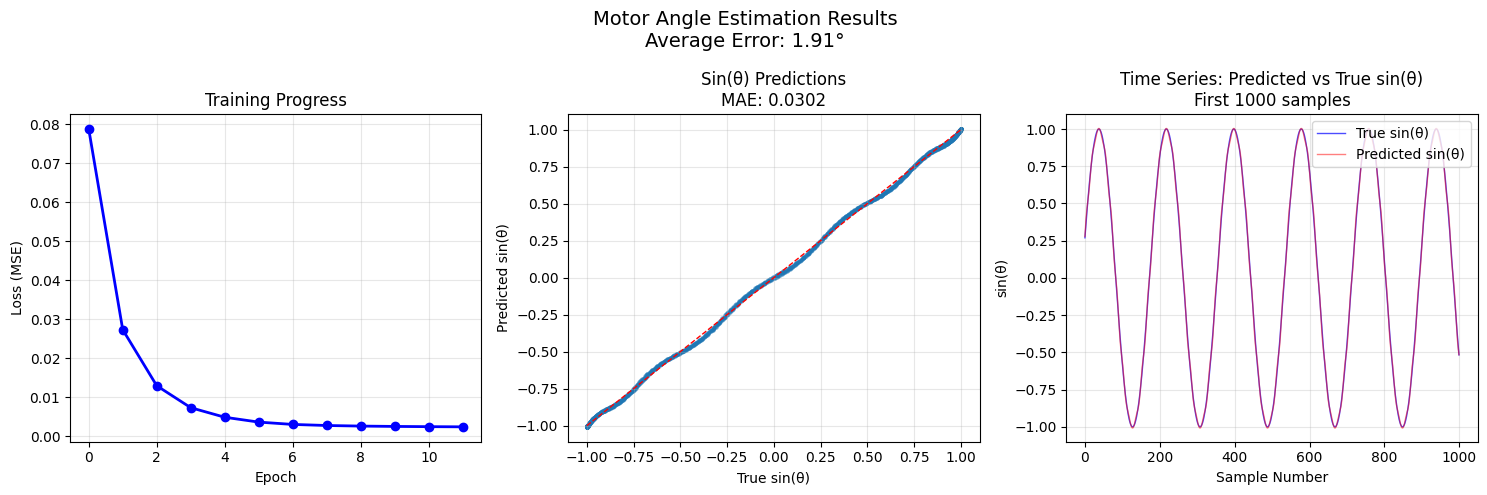


Creating dedicated time series plot...


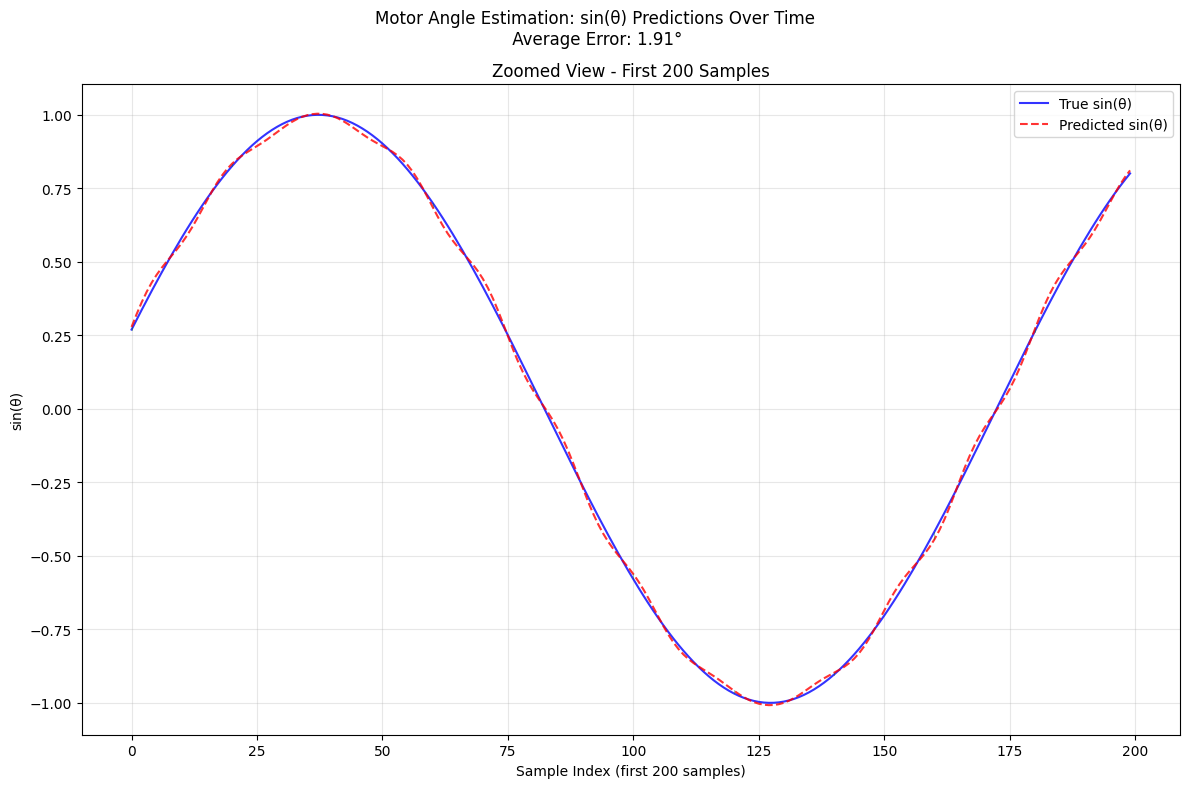

In [90]:
print("Creating plots to visualize performance...")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Motor Angle Estimation Results\nAverage Error: {angle_mae_deg:.2f}°',
             fontsize=14)

# ------------------------------------------------------------
# Plot 1: Training loss over time
# ------------------------------------------------------------
ax = axes[0]
ax.plot(train_losses, 'b-', linewidth=2, marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training Progress')
ax.grid(True, alpha=0.3)
print("✓ Plot 1: Training loss curve")

# ------------------------------------------------------------
# Plot 2: Sin(θ) predictions scatter plot
# ------------------------------------------------------------
ax = axes[1]
# Show first 1000 predictions
ax.scatter(sin_true[:1000], sin_pred[:1000], alpha=0.5, s=5)
ax.plot([-1, 1], [-1, 1], 'r--', linewidth=1)  # Perfect prediction line
ax.set_xlabel('True sin(θ)')
ax.set_ylabel('Predicted sin(θ)')
ax.set_title(f'Sin(θ) Predictions\nMAE: {mae_sin:.4f}')
ax.grid(True, alpha=0.3)
print("✓ Plot 2: sin(θ) predictions scatter plot")

# ------------------------------------------------------------
# Plot 3: TIME SERIES - YOUR REQUESTED PLOT!
# ------------------------------------------------------------
ax = axes[2]
# Show first 1000 samples as time series
n_show = min(1000, len(sin_true))
samples = np.arange(n_show)

# Plot true sin(θ) as blue line
ax.plot(samples, sin_true[:n_show], 'b-', linewidth=1, alpha=0.7, label='True sin(θ)')
# Plot predicted sin(θ) as red line
ax.plot(samples, sin_pred[:n_show], 'r-', linewidth=1, alpha=0.5, label='Predicted sin(θ)')

ax.set_xlabel('Sample Number')
ax.set_ylabel('sin(θ)')
ax.set_title(f'Time Series: Predicted vs True sin(θ)\nFirst {n_show} samples')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim([-1.1, 1.1])

print("✓ Plot 3: Time series plot (your request!)")
print("  Blue = true values, Red = predictions")

plt.tight_layout()
plt.show()

# ============================================================================
# ADDITIONAL: DEDICATED TIME SERIES PLOT
# ============================================================================
print("\nCreating dedicated time series plot...")

fig2, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
fig2.suptitle(f'Motor Angle Estimation: sin(θ) Predictions Over Time\n Average Error: {angle_mae_deg:.2f}°',
              fontsize=12)

# Bottom plot: Zoomed view (first 200 samples)
zoom_samples = 200
ax1.plot(sin_true[:zoom_samples], 'b-', linewidth=1.5, alpha=0.8, label='True sin(θ)')
ax1.plot(sin_pred[:zoom_samples], 'r--', linewidth=1.5, alpha=0.8, label='Predicted sin(θ)')
ax1.set_xlabel(f'Sample Index (first {zoom_samples} samples)')
ax1.set_ylabel('sin(θ)')
ax1.set_title(f'Zoomed View - First {zoom_samples} Samples')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add error bars to zoomed view
for i in range(0, zoom_samples, 20):  # Every 20th sample
    ax1.plot([i, i], [sin_true[i], sin_pred[i]], 'g-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


# model insights

In [ ]:
# Get learned weights from first layer
# weights = model.fc1.weight.data.numpy()
# biases = model.fc1.bias.data.numpy()
weights = model[0].weight.data.numpy()
biases = model[0].bias.data.numpy()

# Calculate parameters:
params = sum(p.numel() for p in model.parameters())

print("Extracted learned weights and biases")
print("\nFirst layer has 12 neurons, each with:")
print("  4 weights (one for each input)")
print("  1 bias (constant offset)")

print("\nExample - Neuron 0 learned:")
print(f"  Weights: [{weights[0,0]:.4f}, {weights[0,1]:.4f}, "
      f"{weights[0,2]:.4f}, {weights[0,3]:.4f}]")
print(f"  Bias: {biases[0]:.4f}")

print("\nWhat this means for prediction:")
print("1. Input: [i_α, i_β, v_α, v_β] (scaled)")
print("2. Each neuron calculates: tanh(w·inputs + bias)")
print("3. Second layer combines neuron outputs")
print("4. Output: [sinθ, cosθ]")

# Test with one example
print("\nTesting with first test sample:")
test_input = torch.FloatTensor([X_test_scaled[0]])
with torch.no_grad():
    test_output = model(test_input)
    sin_pred_example, cos_pred_example = scaler_y.inverse_transform(test_output.numpy())[0]

print(f"  Input (scaled): {test_input[0].numpy()}")
print(f"  Output: sin={sin_pred_example:.4f}, cos={cos_pred_example:.4f}")
print(f"  Estimated angle: {np.degrees(np.arctan2(sin_pred_example, cos_pred_example)):.2f}°")

Extracted learned weights and biases

First layer has 12 neurons, each with:
  4 weights (one for each input)
  1 bias (constant offset)

Example - Neuron 0 learned:
  Weights: [-0.6287, 0.5537, -1.7485, 1.7364]
  Bias: 0.0268

What this means for prediction:
1. Input: [i_α, i_β, v_α, v_β] (scaled)
2. Each neuron calculates: tanh(w·inputs + bias)
3. Second layer combines neuron outputs
4. Output: [sinθ, cosθ]

Testing with first test sample:
  Input (scaled): [-0.2918032   1.0473477  -0.43830156  1.3358548 ]
  Output: sin=0.2786, cos=0.9456
  Estimated angle: 16.41°
